## Modeling

In [207]:
import heapq
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts

In [208]:
class Event:
    """
    Represent each event in the schedule. Used for priority queue.

    Attributes:
        timestamp (float): time for the event to take place
        function (function): function to call when the event takes place
    """
    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        """
        Compare whether the timestamp of this event is earlier than another one.

        Inputs:
          other (Event): another Event instance to be compared with.
        
        Returns:
          bool: True if this event is earlier than the other one, False otherwise.
        """
        return self.timestamp < other.timestamp

    def run(self, schedule):
        """
        Run the function associated with the Event when the it's the timestamp.

        Inputs:
          schedule (Schedule): the schedule with the current event.
        """
        self.function(schedule, *self.args, **self.kwargs)

class Schedule:
    """
    Class to manage events in a schedule.

    Attributes:
        now (float): current timestamp
        priority_queue (list): priority queue of events, comparison by their timestamps.
    """
    def __init__(self):
        self.now = 0 
        self.priority_queue = []  
    
    def add_event_at(self, timestamp, function, *args, **kwargs):
        """
        Add event to the priority queue to take place at a specified timestamp.

        Inputs:
            timestamp (float): timestamp at which to execute the event.
            function (function): function to execute when the event takes place.
        """
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function, *args, **kwargs))
    
    def add_event_after(self, interval, function, *args, **kwargs):
        """
        Add event to the priority queue to take place a certain time interval from now.

        Inputs:
            interval (float): time to wait from current time until executing the event.
            function (function): function to execute when the event takes place.
        """
        self.add_event_at(self.now + interval, function, *args, **kwargs)
    
    def next_event_time(self):
        """
        Return the timestamp of the next event to be executed in the priority queue.
        """
        return self.priority_queue[0].timestamp

    def run_next_event(self):
        """
        Execute the next event in the priority queue and update the current time.
        """
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp
        event.run(self)
        
    def __repr__(self):
        """
        Return information about the overall schedule.
        """
        return (
            f'Schedule() at time {self.now} ' +
            f'with {len(self.priority_queue)} events in the queue')
    
    def print_events(self):
        """
        Print information about the schedule and each event in the schedule.
        """
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'   {event.timestamp}: {event.function.__name__}')

In [209]:
class Customer:
    """
    Class to represent each customer and store information about their activity.

    Attributes:
        id (int): customer's unique ID.
        arrival_time (float): the time the customer joins the queue.
        cashier_start_time (float): the time the cashier starts serving the customer.
        cashier_end_time (float): the time the cashier finishes serving the customer.
        needed_assistance (bool): whether the customer needs assistance from manager.
        manager_queue_arrival_time (float): the time the customer joins the manager queue.
        manager_start_time (float): the time the manager starts helping the customer.
        manager_end_time (float): the time the manager finishes helping the customer.
    """
    def __init__(self, customer_id, arrival_time):
        self.id = customer_id
        self.arrival_time = arrival_time
        self.cashier_start_time = None
        self.cashier_end_time = None
        self.needed_assistance = False
        self.manager_queue_arrival_time = None
        self.manager_start_time = None
        self.manager_end_time = None
    
    def __str__(self):
        """
        Return all information about a customer's activity.

        Returns:
            string: contains information to be displayed about the customer's activity.
        """
        str_ = f"#{self.id}:\nArrival: {round(self.arrival_time, 2)}"
        if self.cashier_start_time:
            str_ += f"\nCashier wait time: {round(self.cashier_start_time - self.arrival_time, 2)}"
        if self.cashier_end_time:
            str_ += f"\nService time: {round(self.cashier_end_time - self.cashier_start_time, 2)}\n"
        if self.needed_assistance:
            str_ += f"\nManager arrival time: {round(self.manager_queue_arrival_time, 2)}"
        if self.manager_start_time:
            str_ += f"\nManager wait time: {round(self.manager_start_time - self.manager_queue_arrival_time, 2)}"
        if self.manager_end_time:
            str_ += f"\nManager service time: {round(self.manager_end_time - self.manager_start_time, 2)}\n"
        return str_

In [210]:
class Queue:
    """
    Represents a queue in the grocery store, includes methods for the cashier to serve the customer.

    Attributes:
        grocery_store (GroceryStore object): the grocery store instance.
        serving (bool): whether the cashier is currently serving a customer or not.
        line (deque): a deque (double ended queue) representing the line of this queue.
        service_distribution (scipy stats distribution): distribution of serve times used to generate samples of service time.
        track_timestamps (list): list of the times that a customer starts being served.
        track_queue_lens (list): list tracking the lengths of the line.
    """
    def __init__(self, service_distribution, grocery_store):
        self.grocery_store = grocery_store
        self.serving = False
        self.line = deque([])
        self.service_distribution = service_distribution
        self.track_timestamps = []
        self.track_queue_lens = []
        
    def done_serving(self, schedule, customer):
        """
        Method to call when a cashier is done serving a customer.

        Inputs:
            schedule (Schedule object): the schedule containing all events.
            customer (Customer object): the customer being served.
        """
        if self.serving:
            # update queue's serving status
            self.serving = False
            # update customer's cashier_end_time to current time
            customer.cashier_end_time = schedule.now

            #print(f"✅Done serving Customer {customer.id} at time {round(schedule.now, 3)}")
            #print_status(self.grocery_store, schedule)

            # if there's a line in the queue, immediately start serving next customer
            if self.line:
                schedule.add_event_after(0, self.serve_next)
            
            # 5% chance that customer needs assistance
            if np.random.rand() < 0.05:
                customer.needed_assistance = True
                customer.manager_queue_arrival_time = schedule.now
                # add event of customer joining the manager queue
                schedule.add_event_after(0, self.grocery_store.manager_arrival, customer)
                
    def serve_next(self, schedule):
        """
        Method to serve next customer in line.

        Inputs:
            schedule (Schedule object): the schedule containing all events.
        """
        # check that cashier is available and there is a line
        if not self.serving and self.line:
            self.serving = True
            # get first customer in line
            customer = self.line.popleft()
            # update tracking lists: current time and line length
            self.track_timestamps.append(schedule.now)
            self.track_queue_lens.append(len(self.line))

            # update tracking list for 
            prev_avg = self.grocery_store.track_avg_queue_lens[-1]
            n_queues = len(self.grocery_store.queues)
            new_avg = (prev_avg*n_queues - 1)/n_queues
            self.grocery_store.track_timestamps.append(schedule.now)
            self.grocery_store.track_avg_queue_lens.append(new_avg)

            # update the customer's cashier_start_time
            customer.cashier_start_time = schedule.now

            # print(f"Started serving Customer {customer.id} at time {round(schedule.now, 3)}")
            # print_status(self.grocery_store, schedule)

            # use max() to avoid negative values from the distribution -- if negative, then service time = 0
            # add event to finish serving the customer after certain service time drawn from distribution
            schedule.add_event_after(max(self.service_distribution.rvs(), 0), self.done_serving, customer)


# overall the structure of the ManagerQueue class is very similar to the Queue class, so there are less detailed comments here.
class ManagerQueue:
    """
    Represents a manager queue, includes methods for the manager to help the customer.

    Attributes:
        serving (bool): whether the manager is currently helping a customer or not.
        line (deque): a deque (double ended queue) representing the line of manager queue.
        manager_service_distribution (scipy stats distribution): distribution of serve times used to generate samples of service time.
        track_timestamps (list): list of the times that a customer starts being helped.
        track_queue_lens (list): list tracking the lengths of the line.
    """
    def __init__(self, manager_service_distribution):
        self.serving = False
        self.line = deque([])
        self.manager_service_distribution = manager_service_distribution
        self.track_timestamps = []
        self.track_queue_lens = []
        
    def done_serving(self, schedule, customer):
        """
        Method to call when the manager is done helping a customer.
        """
        if self.serving:
            self.serving = False
            customer.manager_end_time = schedule.now

            # print(f"✅Manager done serving Customer {customer.id} at time {round(schedule.now, 3)}\n")

            if self.line:
                schedule.add_event_after(0, self.serve_next)
    
    def serve_next(self, schedule):
        """
        Method to call for the manager to help the next customer in line.
        """
        if not self.serving and self.line:
            self.serving = True
            customer = self.line.popleft()
            self.track_timestamps.append(schedule.now)
            self.track_queue_lens.append(len(self.line))
            customer.manager_start_time = schedule.now

            # print(f"Manager started serving Customer {customer.id} at time {round(schedule.now, 3)}")

            schedule.add_event_after(max(self.manager_service_distribution.rvs(), 0), self.done_serving, customer)

In [211]:
class GroceryStore:
    """
    Represents the grocery store being modeled.

    Attributes:
        queues (list): list of Queue instances for each queue in the store.
        manager_queue (ManagerQueue object): manager queue.
        closing time (int): number of minutes since opening.
        arrival_distribution (scipy stats distribution): distribution of arrival time intervals.
        customer_id (int): current customer ID. increases by 1 for each new customer.
        last_arrival (float): the arrival time of the last customer. when this exceeds the closing time, we stop letting customers join.
        all_customers (list): list of all customers who have visited the store.
        track_timestamps (list): list of timestamps for tracking average queue lengths.
        track_avg_queue_lens (list): list of average queue lengths of all queues whenever a customer joins.
        rand_queue (bool): whether to randomly assign a customer to a queue. default set to False. this is only used for testing.
    """
    def __init__(self, closing_time, n_queues, arrival_distribution, service_distribution, manager_service_distribution, rand_queue = False):
        self.queues = [Queue(service_distribution, self) for _ in range(n_queues)]
        self.manager_queue = ManagerQueue(manager_service_distribution)
        self.closing_time = closing_time
        self.arrival_distribution = arrival_distribution
        self.customer_id = 0
        self.last_arrival = 0
        self.all_customers = []
        self.track_timestamps = []
        self.track_avg_queue_lens = []
        self.rand_queue = rand_queue
    
    def find_shortest_line(self):
        """
        Find the index of the queue of shortest line currently.

        Returns:
            ind (int): index of shortest line.
        """
        ind = 0
        min_len = len(self.queues[0].line)
        # find queue with no line or queue with shortest line
        for i in range(1, len(self.queues)):
            if not self.queues[i].serving or len(self.queues[i].line) < min_len:
                ind = i
                min_len = len(self.queues[i].line)
        return ind

    # favour
    def random_gen_ind(self):
        n = len(self.queues)
        return np.random.randint(n)
    
    def arrival(self, schedule, customer):
        """
        Method to call when a customer arrives and joins a queue.

        Inputs:
            schedule (Schedule object): schedule of events of this grocery store.
            customer (Customer object): customer who arrived.
        """
        # add customer to the queue with shortest line
        # add to random queue if self.rand_queue == True
        if self.rand_queue == False:
            ind = self.find_shortest_line()
        else:
            ind = self.random_gen_ind()

        self.queues[ind].line.append(customer)

        #print(f'Customer {customer.id} joined line {ind + 1}')
        #print_status(self, schedule)
        
        sum_queue_len = 0
        # update each queue's tracking with current time and line length
        for i in range(len(self.queues)):
            self.queues[i].track_timestamps.append(schedule.now)
            self.queues[i].track_queue_lens.append(len(self.queues[i].line))
            sum_queue_len += len(self.queues[i].line)
        avg_queue_len = sum_queue_len/len(self.queues)
        # track average queue length at current time
        self.track_timestamps.append(schedule.now)
        self.track_avg_queue_lens.append(avg_queue_len)
                
        self.queues[ind].serve_next(schedule)
        
    def manager_arrival(self, schedule, customer):
        """
        Method to call when a customer joins the manager queue.
        """
        self.manager_queue.line.append(customer)
        # track the current time and length of the manager queue.
        self.manager_queue.track_timestamps.append(schedule.now)
        self.manager_queue.track_queue_lens.append(len(self.manager_queue.line))
        # manager starts serving the customer if available, otherwise the customer waits in line.
        self.manager_queue.serve_next(schedule)
    
    def get_customers_till_closing(self, schedule):
        """
        Generate all customer arrivals until closing time.
        """
        # only allow customers to arrive before the store's closing time
        while self.last_arrival < self.closing_time:
            if self.last_arrival > self.closing_time:
                break
            # draw arrival time interval from distribution
            arrival_interval = self.arrival_distribution.rvs()
            self.customer_id += 1
            # add interval to arrival time tracker
            self.last_arrival += arrival_interval
            customer = Customer(self.customer_id, self.last_arrival)
            self.all_customers.append(customer)
            # schedule event for customer to arrive at the store
            schedule.add_event_at(self.last_arrival, self.arrival, customer)
            
    def run(self, schedule):
        """
        Start running the similation by generating all customer arrivals.
        """
        self.get_customers_till_closing(schedule)


def print_status(grocery_store, schedule):
    """
    Print the current status of the grocery store. Used for checking the model.
    """
    print(f"At timestamp = {schedule.now}, the grocery store queues:")
    for i in range(len(grocery_store.queues)):
        print(f"Queue #{i+1}: {len(grocery_store.queues[i].line)}🧍🏾‍♀️ in the queue")
    print()

## Simulation

In [212]:
def run_simulation(closing_time, arrival_distribution, service_distribution, manager_service_distribution, run_until, n_queues, print_queue = True, rand_queue = False):
    """
    Function to run the simulation given inputs and give status of the store after the simulation ends.

    Inputs:
        closing_time (int): number of minutes from opening
        arrival_distribution (scipy stats distribution): distribution of arrival time intervals
        service_distribution (scipy stats distribution): distribution of service times
        manager_service_distribution (scipy stats distribution): distribution of manager service times
        run_until: (int) length of the simulation
        n_queues (int): number of queues in the store
        print (bool): whether to print information about the queues after simulation ends

    Returns:
        store (GroceryStore object)
    """
    schedule = Schedule()
    store = GroceryStore(closing_time, n_queues, arrival_distribution, 
                         service_distribution, manager_service_distribution, rand_queue)
    # initialize simulation by scheduling arrivals
    store.run(schedule)
    # if the simulation is scheduled to end before closing time, keep running next event until hitting run_until
    if run_until < closing_time:
        while schedule.now <= run_until:
            schedule.run_next_event()
    # if the simulation is scheduled to end after closing time, run simulation until completion (clearing the schedule)
    else:
        while schedule.priority_queue:
            schedule.run_next_event()
    if print_queue == True:
        print("At the end of the simulation:")
        for i in range(len(store.queues)):
            print(f"Queue #{i+1}: {len(store.queues[i].line)}🧍🏾‍♀️ in the queue")
        print()
    return store

In [ ]:
# DO NOT RERUN THIS CELL
# this output is use to check that customers join the shortest queue. simulation for 5 timestamps.

arrival_distribution = sts.expon(scale=1/1)
service_distribution = sts.norm(loc=3, scale=1)
manager_service_distribution = sts.norm(loc=5, scale=2)

# closing_time = 660 (minutes) -- that is 11 hours (8pm is 11 hours from opening time of 9am)
# run for 500 minutes
# 3 queues
grocery_store = run_simulation(660, arrival_distribution, service_distribution, 
                               manager_service_distribution, 5, 3)

Customer 1 joined line 3
At timestamp = 0.2763219822965728, the grocery store queues:
Queue #1: 0🧍🏾‍♀️ in the queue
Queue #2: 0🧍🏾‍♀️ in the queue
Queue #3: 1🧍🏾‍♀️ in the queue

Started serving Customer 1 at time 0.276
At timestamp = 0.2763219822965728, the grocery store queues:
Queue #1: 0🧍🏾‍♀️ in the queue
Queue #2: 0🧍🏾‍♀️ in the queue
Queue #3: 0🧍🏾‍♀️ in the queue

Customer 2 joined line 2
At timestamp = 0.30953310530853156, the grocery store queues:
Queue #1: 0🧍🏾‍♀️ in the queue
Queue #2: 1🧍🏾‍♀️ in the queue
Queue #3: 0🧍🏾‍♀️ in the queue

Started serving Customer 2 at time 0.31
At timestamp = 0.30953310530853156, the grocery store queues:
Queue #1: 0🧍🏾‍♀️ in the queue
Queue #2: 0🧍🏾‍♀️ in the queue
Queue #3: 0🧍🏾‍♀️ in the queue

Customer 3 joined line 1
At timestamp = 1.2972314110575818, the grocery store queues:
Queue #1: 1🧍🏾‍♀️ in the queue
Queue #2: 0🧍🏾‍♀️ in the queue
Queue #3: 0🧍🏾‍♀️ in the queue

Started serving Customer 3 at time 1.297
At timestamp = 1.2972314110575818, the gr

In [213]:
arrival_distribution = sts.expon(scale=1/1)
service_distribution = sts.norm(loc=3, scale=1)
manager_service_distribution = sts.norm(loc=5, scale=2)

# closing_time = 660 (minutes) -- that is 11 hours (8pm is 11 hours from opening time of 9am)
# run for 500 timestamps -- not till completion
# 4 queues
grocery_store = run_simulation(660, arrival_distribution, service_distribution, 
                               manager_service_distribution, 500, 4)

At the end of the simulation:
Queue #1: 1🧍🏾‍♀️ in the queue
Queue #2: 0🧍🏾‍♀️ in the queue
Queue #3: 0🧍🏾‍♀️ in the queue
Queue #4: 0🧍🏾‍♀️ in the queue



## Theoretical Analysis

In [214]:
theo_avg_wait_time = []
theo_avg_response_time = []
theo_avg_queue_length = []

sigma_cashier = 1
tau_cashier = 3
sigma_manager = 2
tau_manager = 5

for n in range(4, 10):
    lambda_cashier = 1/n
    lambda_manager = 0.05
    rho_cashier = lambda_cashier * tau_cashier
    rho_manager = lambda_manager * tau_manager

    avg_wait_time = ((rho_cashier * tau_cashier)/(2 * (1-rho_cashier))) * (1 + (sigma_cashier**2)/(tau_cashier**2))
    # include wait time in manager line
    avg_manager_wait_time = 0.05 * (((rho_manager * tau_manager)/(2 * (1-rho_manager))) * (1 + (sigma_manager**2)/(tau_manager**2)))
    theo_avg_wait_time.append(avg_wait_time + avg_manager_wait_time)

    avg_response_time = tau_cashier + tau_manager * 0.05 + avg_wait_time
    theo_avg_response_time.append(avg_response_time)

    avg_queue_length = avg_wait_time * lambda_cashier
    theo_avg_queue_length.append(avg_queue_length)

    print(f'Number of queues = {n}')
    print(f"---Average wait time: {round(avg_wait_time + avg_manager_wait_time, 2)}")
    print(f"---Average response time: {round(avg_response_time, 2)}")
    print(f"---Average queue length: {round(avg_queue_length, 2)}")
    print()

Number of queues = 4
---Average wait time: 5.05
---Average response time: 8.25
---Average queue length: 1.25

Number of queues = 5
---Average wait time: 2.55
---Average response time: 5.75
---Average queue length: 0.5

Number of queues = 6
---Average wait time: 1.72
---Average response time: 4.92
---Average queue length: 0.28

Number of queues = 7
---Average wait time: 1.3
---Average response time: 4.5
---Average queue length: 0.18

Number of queues = 8
---Average wait time: 1.05
---Average response time: 4.25
---Average queue length: 0.12

Number of queues = 9
---Average wait time: 0.88
---Average response time: 4.08
---Average queue length: 0.09



## Empirical Analysis

In [215]:
def find_metrics(grocery_store):
    """
    Find the four metrics for the grocery store after the simulation. Store as attributes.
    """
    grocery_store.wait_times = []
    grocery_store.service_times = []
    grocery_store.response_times = []

    for customer in grocery_store.all_customers:
        if customer.cashier_start_time and customer.cashier_end_time:
            wait_time = round(customer.cashier_start_time - customer.arrival_time, 2)
            service_time = round(customer.cashier_end_time - customer.cashier_start_time, 2)
            if customer.manager_start_time and customer.manager_end_time:
                wait_time += round(customer.manager_start_time - customer.manager_queue_arrival_time, 2)
                service_time += round(customer.manager_end_time - customer.manager_start_time, 2)
            grocery_store.wait_times.append(wait_time)
            grocery_store.service_times.append(service_time)
            grocery_store.response_times.append(wait_time + service_time)

    # metric: avg waiting time
    grocery_store.avg_wait_time = np.average(grocery_store.wait_times)

    # metric: avg response time
    grocery_store.avg_response_time = np.average(grocery_store.response_times)
    
    # metric: max queue length
    m = 0
    for i in range(len(grocery_store.queues)):
        if max(grocery_store.queues[i].track_queue_lens) > m:
            m = max(grocery_store.queues[i].track_queue_lens)
    grocery_store.max_queue_length = m

    # metric: average queue length
    grocery_store.avg_queue_length = np.average(grocery_store.track_avg_queue_lens)


def compute_95_interval(data):
    """
    Compute the average queue length, standard error, and 95% confidence interval.
    """
    m = np.mean(data)
    m_approx = round(m, 2)
    t = sts.sem(data)
    t_approx = round(t, 2)
    return m_approx, t_approx

In [216]:
# save experiment data
shortest_queue_data = {}
random_queue_data = {}

def trials(n_trials, n_queues):
    shortest_queue_data[n_queues] = [],[],[],[]
    random_queue_data[n_queues] = [],[],[],[]

    for _ in range(n_trials):
        # shortst queue approach
        grocery_store = run_simulation(660, arrival_distribution, service_distribution, 
                                      manager_service_distribution, 700, n_queues, print_queue = False)
        find_metrics(grocery_store)
        # save metrics
        shortest_queue_data[n_queues][0].append(grocery_store.avg_wait_time)
        shortest_queue_data[n_queues][1].append(grocery_store.avg_response_time)
        shortest_queue_data[n_queues][2].append(grocery_store.max_queue_length)
        shortest_queue_data[n_queues][3].append(grocery_store.avg_queue_length)

        # random queue approach (note rand_queue = True)
        grocery_store = run_simulation(660, arrival_distribution, service_distribution, 
                                      manager_service_distribution, 700, n_queues, print_queue = False, rand_queue = True)
        find_metrics(grocery_store)
        
        random_queue_data[n_queues][0].append(grocery_store.avg_wait_time)
        random_queue_data[n_queues][1].append(grocery_store.avg_response_time)
        random_queue_data[n_queues][2].append(grocery_store.max_queue_length)
        random_queue_data[n_queues][3].append(grocery_store.avg_queue_length)

In [217]:
# run 100 trials for each n_queues
for n_queues in range(4,10):
    trials(100, n_queues)

In [218]:
shortest_queue_plot_data = {}
random_queue_plot_data = {}

# find mean and standard deviation for metrics for plotting
for metric in range(0,4):
    shortest_queue_plot_data[metric] = [[],[]]
    random_queue_plot_data[metric] = [[],[]]
    for n_queues in range(4,10):
        short_mean, short_se = compute_95_interval(shortest_queue_data[n_queues][metric])
        rand_mean, rand_se = compute_95_interval(random_queue_data[n_queues][metric])
        shortest_queue_plot_data[metric][0].append(short_mean)
        shortest_queue_plot_data[metric][1].append(short_se)
        random_queue_plot_data[metric][0].append(rand_mean)
        random_queue_plot_data[metric][1].append(rand_se)

In [219]:
def error_plot_theo(y, y_error, theoretical, xlabel, ylabel, title):
    """
    Show error plot with 95% confidence interval, including theoretical values.
    """
    plt.figure()
    plt.errorbar(range(4,10), y, y_error,
                 color='black', marker='o', capsize=5, linestyle='--', linewidth=1, label='empirical')
    plt.plot(range(4,10), theoretical, 
             color='red', marker='o',  linestyle='--', linewidth=1, label='theoretical')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.title(title)
    plt.show()

def error_plot(y, y_error, xlabel, ylabel, title):
    """
    Show error plot with 95% confidence interval.
    """
    plt.figure()
    plt.errorbar(range(4,10), y, y_error,
                 color='black', marker='o', capsize=5, linestyle='--', linewidth=1)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

### Shortest Queue

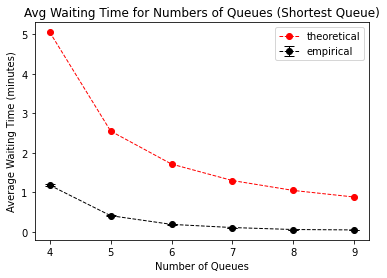

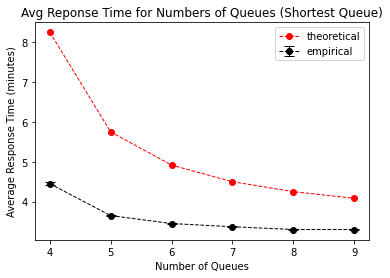

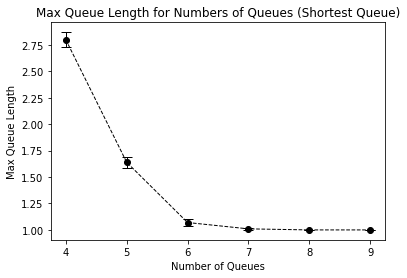

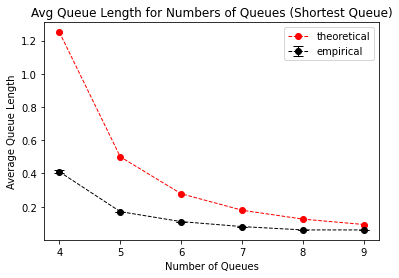

In [220]:
error_plot_theo(shortest_queue_plot_data[0][0], shortest_queue_plot_data[0][1],theo_avg_wait_time,'Number of Queues', 'Average Waiting Time (minutes)', 'Avg Waiting Time for Numbers of Queues (Shortest Queue)')
error_plot_theo(shortest_queue_plot_data[1][0], shortest_queue_plot_data[1][1],theo_avg_response_time,'Number of Queues', 'Average Response Time (minutes)', 'Avg Reponse Time for Numbers of Queues (Shortest Queue)')
error_plot(shortest_queue_plot_data[2][0], shortest_queue_plot_data[2][1],'Number of Queues', 'Max Queue Length', 'Max Queue Length for Numbers of Queues (Shortest Queue)')
error_plot_theo(shortest_queue_plot_data[3][0], shortest_queue_plot_data[3][1],theo_avg_queue_length,'Number of Queues', 'Average Queue Length', 'Avg Queue Length for Numbers of Queues (Shortest Queue)')

In [221]:
for n in range(4,10):
    print(f'Number of queues = {n}')
    print(f"---Average wait time: {shortest_queue_plot_data[0][0][n-4]}")
    print(f"---Average response time: {shortest_queue_plot_data[1][0][n-4]}")
    print(f"---Maximum queue length: {shortest_queue_plot_data[2][0][n-4]}")
    print(f"---Average queue length: {shortest_queue_plot_data[3][0][n-4]}")
    print()

Number of queues = 4
---Average wait time: 1.18
---Average response time: 4.45
---Maximum queue length: 2.8
---Average queue length: 0.41

Number of queues = 5
---Average wait time: 0.41
---Average response time: 3.65
---Maximum queue length: 1.64
---Average queue length: 0.17

Number of queues = 6
---Average wait time: 0.19
---Average response time: 3.45
---Maximum queue length: 1.07
---Average queue length: 0.11

Number of queues = 7
---Average wait time: 0.11
---Average response time: 3.37
---Maximum queue length: 1.01
---Average queue length: 0.08

Number of queues = 8
---Average wait time: 0.06
---Average response time: 3.3
---Maximum queue length: 1.0
---Average queue length: 0.06

Number of queues = 9
---Average wait time: 0.05
---Average response time: 3.3
---Maximum queue length: 1.0
---Average queue length: 0.06



### Random Queue

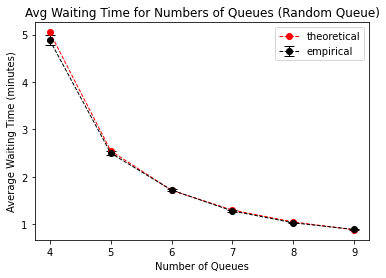

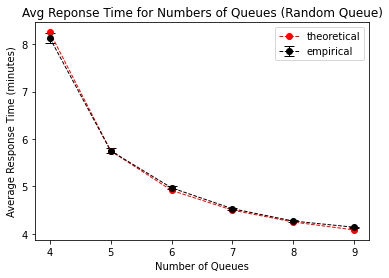

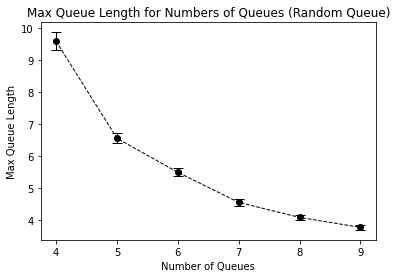

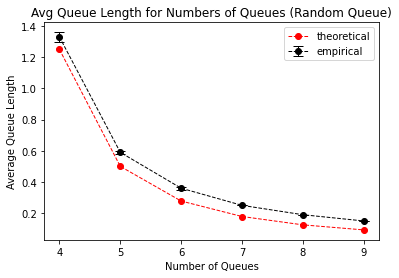

In [222]:
error_plot_theo(random_queue_plot_data[0][0], random_queue_plot_data[0][1],theo_avg_wait_time,'Number of Queues', 'Average Waiting Time (minutes)', 'Avg Waiting Time for Numbers of Queues (Random Queue)')
error_plot_theo(random_queue_plot_data[1][0], random_queue_plot_data[1][1],theo_avg_response_time,'Number of Queues', 'Average Response Time (minutes)', 'Avg Reponse Time for Numbers of Queues (Random Queue)')
error_plot(random_queue_plot_data[2][0], random_queue_plot_data[2][1],'Number of Queues', 'Max Queue Length', 'Max Queue Length for Numbers of Queues (Random Queue)')
error_plot_theo(random_queue_plot_data[3][0], random_queue_plot_data[3][1],theo_avg_queue_length,'Number of Queues', 'Average Queue Length', 'Avg Queue Length for Numbers of Queues (Random Queue)')

In [223]:
for n in range(4,10):
    print(f'Number of queues = {n}')
    print(f"---Average wait time: {random_queue_plot_data[0][0][n-4]}")
    print(f"---Average response time: {random_queue_plot_data[1][0][n-4]}")
    print(f"---Maximum queue length: {random_queue_plot_data[2][0][n-4]}")
    print(f"---Average queue length: {random_queue_plot_data[3][0][n-4]}")
    print()

Number of queues = 4
---Average wait time: 4.88
---Average response time: 8.13
---Maximum queue length: 9.58
---Average queue length: 1.33

Number of queues = 5
---Average wait time: 2.5
---Average response time: 5.75
---Maximum queue length: 6.55
---Average queue length: 0.59

Number of queues = 6
---Average wait time: 1.72
---Average response time: 4.97
---Maximum queue length: 5.49
---Average queue length: 0.36

Number of queues = 7
---Average wait time: 1.28
---Average response time: 4.53
---Maximum queue length: 4.55
---Average queue length: 0.25

Number of queues = 8
---Average wait time: 1.03
---Average response time: 4.27
---Maximum queue length: 4.08
---Average queue length: 0.19

Number of queues = 9
---Average wait time: 0.89
---Average response time: 4.14
---Maximum queue length: 3.77
---Average queue length: 0.15



## Test Cases
We are doing this at the end of the notebook because we need some of the function defined previously.

In [224]:
# Test Case 1

# Do queues reach 0 after the closing time has been achieved
# meaning no further customers are taken in and all customers in the queue are served?

arrival_distribution = sts.expon(scale=1/1)
service_distribution = sts.norm(loc=3, scale=1)
manager_service_distribution = sts.norm(loc=5, scale=2)

# run_until = 660 -- as long as we hit closing hour, the simulation will be run till completion
for i in range(1, 8):
  print(f'Number of queues = {i}')
  grocery_store = run_simulation(660, arrival_distribution, service_distribution, 
                               manager_service_distribution, 660, i)

Number of queues = 1
At the end of the simulation:
Queue #1: 0🧍🏾‍♀️ in the queue

Number of queues = 2
At the end of the simulation:
Queue #1: 0🧍🏾‍♀️ in the queue
Queue #2: 0🧍🏾‍♀️ in the queue

Number of queues = 3
At the end of the simulation:
Queue #1: 0🧍🏾‍♀️ in the queue
Queue #2: 0🧍🏾‍♀️ in the queue
Queue #3: 0🧍🏾‍♀️ in the queue

Number of queues = 4
At the end of the simulation:
Queue #1: 0🧍🏾‍♀️ in the queue
Queue #2: 0🧍🏾‍♀️ in the queue
Queue #3: 0🧍🏾‍♀️ in the queue
Queue #4: 0🧍🏾‍♀️ in the queue

Number of queues = 5
At the end of the simulation:
Queue #1: 0🧍🏾‍♀️ in the queue
Queue #2: 0🧍🏾‍♀️ in the queue
Queue #3: 0🧍🏾‍♀️ in the queue
Queue #4: 0🧍🏾‍♀️ in the queue
Queue #5: 0🧍🏾‍♀️ in the queue

Number of queues = 6
At the end of the simulation:
Queue #1: 0🧍🏾‍♀️ in the queue
Queue #2: 0🧍🏾‍♀️ in the queue
Queue #3: 0🧍🏾‍♀️ in the queue
Queue #4: 0🧍🏾‍♀️ in the queue
Queue #5: 0🧍🏾‍♀️ in the queue
Queue #6: 0🧍🏾‍♀️ in the queue

Number of queues = 7
At the end of the simulation:
Queue #

In [ ]:
# Test Case 2

# Does increasing the rate of arrival makes sure that the queue length keeps increasing?

# arrival rate is 100 customers per minute
arrival_distribution = sts.expon(scale=1/100)
service_distribution = sts.norm(loc=3, scale=1)
manager_service_distribution = sts.norm(loc=5, scale=2)

grocery_store = run_simulation(660, arrival_distribution, service_distribution, 
                               manager_service_distribution, 500, 10)

At the end of the simulation:
Queue #1: 4798🧍🏾‍♀️ in the queue
Queue #2: 4798🧍🏾‍♀️ in the queue
Queue #3: 4798🧍🏾‍♀️ in the queue
Queue #4: 4798🧍🏾‍♀️ in the queue
Queue #5: 4798🧍🏾‍♀️ in the queue
Queue #6: 4797🧍🏾‍♀️ in the queue
Queue #7: 4797🧍🏾‍♀️ in the queue
Queue #8: 4797🧍🏾‍♀️ in the queue
Queue #9: 4797🧍🏾‍♀️ in the queue
Queue #10: 4797🧍🏾‍♀️ in the queue



In [225]:
# Test Case 3

# checking that when we only have one queue, the output metrics align with theoretical results

# arrival rate of 1 customer per minute
# 0.8 minutes per customer service time
arrival_distribution = sts.expon(scale=1/1)
service_distribution = sts.norm(loc=0.8, scale=0.2)
manager_service_distribution = sts.norm(loc=2, scale=1)

waiting_times = []
avg_queue_lengths = []
for i in range(100):
    grocery_store = run_simulation(660, arrival_distribution, service_distribution, 
                                  manager_service_distribution, 660, 1, print_queue = False)
    find_metrics(grocery_store)
    waiting_times.append(grocery_store.avg_wait_time)
    avg_queue_lengths.append(grocery_store.avg_queue_length)

print(f'Empirical results: average waiting time = {np.average(waiting_times)}, average queue length = {np.average(avg_queue_lengths)}')

Empirical results: average waiting time = 1.60001639235731, average queue length = 2.070723250007835


In [227]:
sigma_cashier = 0.2
tau_cashier = 0.8
sigma_manager = 1
tau_manager = 2

n=1
lambda_cashier = 1/n
lambda_manager = 0.05
rho_cashier = lambda_cashier * tau_cashier
rho_manager = lambda_manager * tau_manager

avg_wait_time = ((rho_cashier * tau_cashier)/(2 * (1-rho_cashier))) * (1 + (sigma_cashier**2)/(tau_cashier**2))
avg_manager_wait_time = 0.05 * (((rho_manager * tau_manager)/(2 * (1-rho_manager))) * (1 + (sigma_manager**2)/(tau_manager**2)))
theo_avg_wait_time.append(avg_wait_time + avg_manager_wait_time)

avg_queue_length = avg_wait_time * lambda_cashier
theo_avg_queue_length.append(avg_queue_length)

print(f'Number of queues = {n}')
print(f"---Average wait time: {round(avg_wait_time + avg_manager_wait_time, 2)}")
print(f"---Average queue length: {round(avg_queue_length, 2)}")

Number of queues = 1
---Average wait time: 1.71
---Average queue length: 1.7


Test Case 3: average wait time aligns with the theoretical analysis. There is a gap in average queue length, but we obsere the same difference in all of our experiments.